# **Project: Clustering for Human Activity Recognition using Smartphones**

# **Dataset**

## **Downloading**

In [1]:
!curl https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip --output "dataset.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58.1M    0 58.1M    0     0   9.9M      0 --:--:--  0:00:05 --:--:-- 11.9M


In [2]:
!unzip dataset.zip

Archive:  dataset.zip
 extracting: UCI HAR Dataset.names   
 extracting: UCI HAR Dataset.zip     


In [3]:
!unzip "UCI HAR Dataset.zip"

Archive:  UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating: UCI HAR

## **Importing**

In [298]:
# Create a function to append occurrence numbers only to duplicate feature names
def adjust_duplicate_feature_names(features):
    # Count the occurrences of each feature name
    feature_counts = features['feature_name'].value_counts()
    # Filter out the unique feature names
    duplicate_features = feature_counts[feature_counts > 1]

    # Initialize a dictionary to hold the new feature names
    new_feature_names = {}

    # Iterate over the feature names
    for feature in features['feature_name']:
        # If the feature is a duplicate, append an occurrence number
        if feature in duplicate_features.index:
            if feature in new_feature_names:
                new_feature_names[feature] += 1
            else:
                new_feature_names[feature] = 1
            yield f"{feature}_{new_feature_names[feature]}"
        else:
            yield feature

In [299]:
import pandas as pd
import numpy as np

# Define file paths
train_data_path = f'UCI HAR Dataset/train/X_train.txt'
test_data_path = f'UCI HAR Dataset/test/X_test.txt'
train_labels_path = f'UCI HAR Dataset/train/y_train.txt'
test_labels_path = f'UCI HAR Dataset/test/y_test.txt'

# Load feature names
features_path = f'UCI HAR Dataset/features.txt'
features = pd.read_csv(features_path, delim_whitespace=True, header=None, names=['feature_index', 'feature_name'])

# We found some duplicate feature names, so we will add integers to the duplicated entries
unique_feature_names = list(adjust_duplicate_feature_names(features))

# Load datasets
train_data = pd.read_csv(train_data_path, delim_whitespace=True, header=None, names=unique_feature_names)
test_data = pd.read_csv(test_data_path, delim_whitespace=True, header=None, names=unique_feature_names)
train_labels = pd.read_csv(train_labels_path, header=None, names=['activity'])
test_labels = pd.read_csv(test_labels_path, header=None, names=['activity'])

# Combining train and test data
df_data = pd.concat([train_data, test_data])
df_labels = pd.concat([train_labels, test_labels])

df_data.reset_index(drop=True, inplace=True)
df_labels.reset_index(drop=True, inplace=True)

# Display the first few rows of the combined data
df_data.shape, df_labels.shape

((10299, 561), (10299, 1))

# **Data Preprocessing**

## **Missing values**

In [300]:
# Now, recheck for missing values in the combined data set
missing_data = df_data.isnull().sum().sum()
missing_labels = df_labels.isnull().sum().sum()
print("Total Missing", missing_data)
print("Labels Missing", missing_labels)

Total Missing 0
Labels Missing 0


## **Standardization**

In [301]:
from sklearn.preprocessing import StandardScaler
# Normalize the feature data of the combined data set
scaler = StandardScaler()
normalized = scaler.fit_transform(df_data)

# Convert normalized data back to a DataFrame for readability and further processing, using combined data set
df_normalized = pd.DataFrame(normalized, columns=unique_feature_names)

# Checking if standardization procedure made a difference
print("Previous Mean:", df_data.mean().abs().mean())
print("Current Mean", df_normalized.mean().abs().mean()) # Should be closer to 0
print("Previous Std:", df_data.std().mean())
print("Current Std", df_normalized.std().mean()) # Should be closer to 1

Previous Mean: 0.5784368041833694
Current Mean 2.240986295182897e-16
Previous Std: 0.2792315133919095
Current Std 1.0000485519384645


## **Outliers Removal**

In [329]:
import pandas as pd

data = df_normalized.copy()

Q1 = data.quantile(0.05)
Q3 = data.quantile(0.95)
IQR = Q3 - Q1

# Multiplier to be more lenient or strict
multiplier = 1

# Checking how many outliers are detected per feature
outliers = (data < (Q1 - multiplier * IQR)) | (data > (Q3 + multiplier * IQR))
outliers_count_per_feature = outliers.sum()

outlier_indices = outliers.any(axis=1)
outlier_indices_list = outlier_indices[outlier_indices].index.tolist()
# Apply the outlier removal only if you are certain it's justified
df_data_cleaned = data.drop(outlier_indices_list)
df_labels = df_labels.drop(outlier_indices_list)

print("Before Outlier Removal Rows:", df_normalized.shape[0])
print('After Outlier Removal Rows:', df_data_cleaned.shape[0])

Before Outlier Removal Rows: 10299
After Outlier Removal Rows: 7663


## **Feature Selection**

### **Correlation Matrix**

In [341]:
import pandas as pd

# Sample data frame creation
df = pd.concat([df_data_cleaned, df_labels], axis=1)

# Assume 'target_feature' is the name of your target column
target_feature = 'activity'

# Calculate the correlation matrix
corr_matrix = df.corr().abs()

# Select only the correlations for the target feature
target_corr = corr_matrix[target_feature].drop(target_feature)

# Find the index of feature columns with high correlation
high_threshold = 0.8
to_drop_high = target_corr[target_corr > high_threshold].index.tolist()

# Find the index of feature columns with extremely low correlation
low_threshold = 0.2
to_drop_low = target_corr[target_corr < low_threshold].index.tolist()

# Combine the two lists of columns to drop
to_drop = list(set(to_drop_high + to_drop_low))

# Drop the features
df_correlated = df.drop(to_drop, axis=1)
print("Previous Shape:", to_drop)
print("New Shape:", df_correlated.shape)

Previous Shape: ['fBodyBodyGyroJerkMag-entropy()', 'tBodyGyro-correlation()-X,Y', 'fBodyBodyGyroMag-kurtosis()', 'fBodyAccMag-entropy()', 'fBodyAccJerk-mean()-Z', 'fBodyAcc-mad()-Z', 'fBodyGyro-sma()', 'tBodyAccJerk-std()-Z', 'tBodyGyro-correlation()-X,Z', 'fBodyBodyGyroMag-mean()', 'tGravityAcc-iqr()-X', 'tBodyAccJerk-mean()-Z', 'fBodyAcc-kurtosis()-Z', 'tBodyAccJerkMag-arCoeff()4', 'tGravityAcc-arCoeff()-Z,1', 'tBodyAccJerk-std()-Y', 'tBodyGyroJerk-mad()-X', 'tBodyGyroJerk-entropy()-Z', 'fBodyAccJerk-mad()-Y', 'fBodyAccJerk-entropy()-X', 'tBodyGyroMag-arCoeff()1', 'fBodyAcc-energy()-Y', 'tBodyGyro-sma()', 'tGravityAcc-correlation()-X,Y', 'tBodyGyro-min()-Z', 'tBodyGyroMag-sma()', 'tBodyAccJerkMag-arCoeff()3', 'fBodyAccJerk-mean()-X', 'fBodyGyro-skewness()-Z', 'tBodyGyroJerk-arCoeff()-Y,3', 'tBodyGyro-iqr()-Z', 'tBodyAccJerk-mad()-Y', 'tBodyAccJerk-iqr()-X', 'tBodyAccJerkMag-iqr()', 'tBodyGyro-mean()-X', 'tBodyAccJerk-mad()-Z', 'tBodyAccJerk-min()-Y', 'fBodyAcc-max()-Y', 'fBodyAccJerk

### **Mutual Info**

In [342]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

# For classification tasks
mutual_info = mutual_info_classif(df_correlated, df_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### **Random Forest Features**

In [343]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# For classification tasks
model = RandomForestClassifier()
model.fit(df_correlated, df_labels)
feature_importance = model.feature_importances_

<ipython-input-343-6cabefa549c8>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(df_correlated, df_labels)


In [344]:
import numpy as np

# Sample data for demonstration
# mutual_info = np.random.rand(100)  # Array of mutual information scores
# feature_importance = np.random.rand(100)  # Array of feature importance scores

# Define the number of top features to keep
top_n = 20

# Select indices of top features based on their importance scores
selected_indices_mi = mutual_info.argsort()[-top_n:][::-1]
selected_indices_fi = feature_importance.argsort()[-top_n:][::-1]

# Create sets from selected indices to identify the unique ones
set_mi = set(selected_indices_mi)
set_fi = set(selected_indices_fi)

# Find the union of selected indices to keep any feature that is important in either method
selected_indices_union = list(set_mi.union(set_fi))

# Ensure that the indices are in sorted order for consistency
selected_indices_union.sort()

print("Total columns to keep:", len(selected_indices_union))

# Keeping only the selected features in your DataFrame
df_filtered = df_correlated.iloc[:, selected_indices_union]

Total columns to keep: 30


In [345]:
df_filtered.shape

(7663, 30)

# **Modeling**

## **KMeans**

### **Determing no. of clusters**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

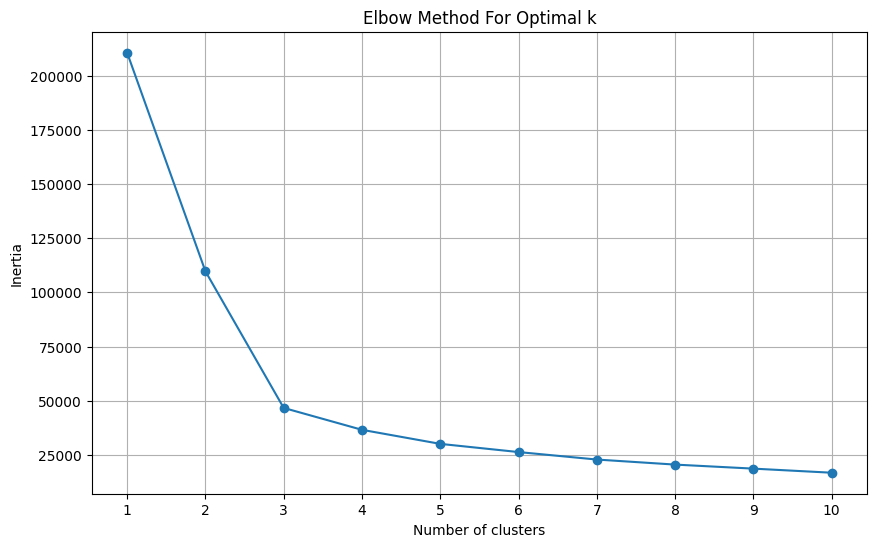

In [359]:
# Elbow method

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_filtered)
    inertia.append(kmeans.inertia_)

# Plot the inertia to see the "elbow"
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

### **Finding best parameters**

In [360]:
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import make_scorer

# Define a custom scorer function for GridSearchCV.
# Inertia (sum of squared distances to the closest centroid) is not directly available as a scorer,
# so we define our own. Lower inertia means tighter clusters, which is what we want.
def inertia_scorer(estimator, X):
    return -estimator.inertia_

# Create a scorer from the scoring function
scorer = make_scorer(inertia_scorer)

# Define the parameters grid to search
param_grid = {
    'n_clusters': [2, 3],    # Number of clusters
    'init': ['k-means++', 'random'],  # Initialization method
    'n_init': [10, 15, 20],         # Number of initializations to perform
    'max_iter': [300, 400, 500],    # Maximum number of iterations
    'tol': [1e-4, 1e-3, 1e-2]       # Tolerance for declaring convergence
}

# Create the GridSearchCV object for KMeans
grid_search = GridSearchCV(KMeans(random_state=10), param_grid, scoring=scorer, cv=3, verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(df_filtered)

# The best parameters from fitting the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


({'init': 'k-means++',
  'max_iter': 300,
  'n_clusters': 2,
  'n_init': 10,
  'tol': 0.0001},
 nan)

### **Clustering**

In [362]:
from sklearn.cluster import KMeans
import numpy as np

# Apply KMeans with 2 clusters
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, tol=0.0001, random_state=10)
cluster_labels = kmeans.fit_predict(df_filtered)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
data_clustered_df = df_filtered.copy()
data_clustered_df['cluster'] = cluster_labels

In [363]:
from sklearn.metrics import silhouette_score
from sklearn import metrics

# Metrics
score = silhouette_score(df_filtered, cluster_labels)
print("Silhouette Score", score)
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(df_labels.values.flatten(), cluster_labels)}")
print(f"Normalized Mutual Information: {metrics.normalized_mutual_info_score(df_labels.values.flatten(), cluster_labels)}")
print(f"V-measure: {metrics.v_measure_score(df_labels.values.flatten(), cluster_labels)}")

Silhouette Score 0.48560426213184066
Adjusted Rand Index: 0.32194577961295695
Normalized Mutual Information: 0.5470404369191778
V-measure: 0.5470404369191777


In [364]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=10)
tsne_results = tsne.fit_transform(df_filtered)
# Create a DataFrame to hold the t-SNE results and the cluster assignments
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7663 samples in 0.002s...
[t-SNE] Computed neighbors for 7663 samples in 0.522s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7663
[t-SNE] Computed conditional probabilities for sample 2000 / 7663
[t-SNE] Computed conditional probabilities for sample 3000 / 7663
[t-SNE] Computed conditional probabilities for sample 4000 / 7663
[t-SNE] Computed conditional probabilities for sample 5000 / 7663
[t-SNE] Computed conditional probabilities for sample 6000 / 7663
[t-SNE] Computed conditional probabilities for sample 7000 / 7663
[t-SNE] Computed conditional probabilities for sample 7663 / 7663
[t-SNE] Mean sigma: 0.215433
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.651176
[t-SNE] KL divergence after 300 iterations: 1.795248


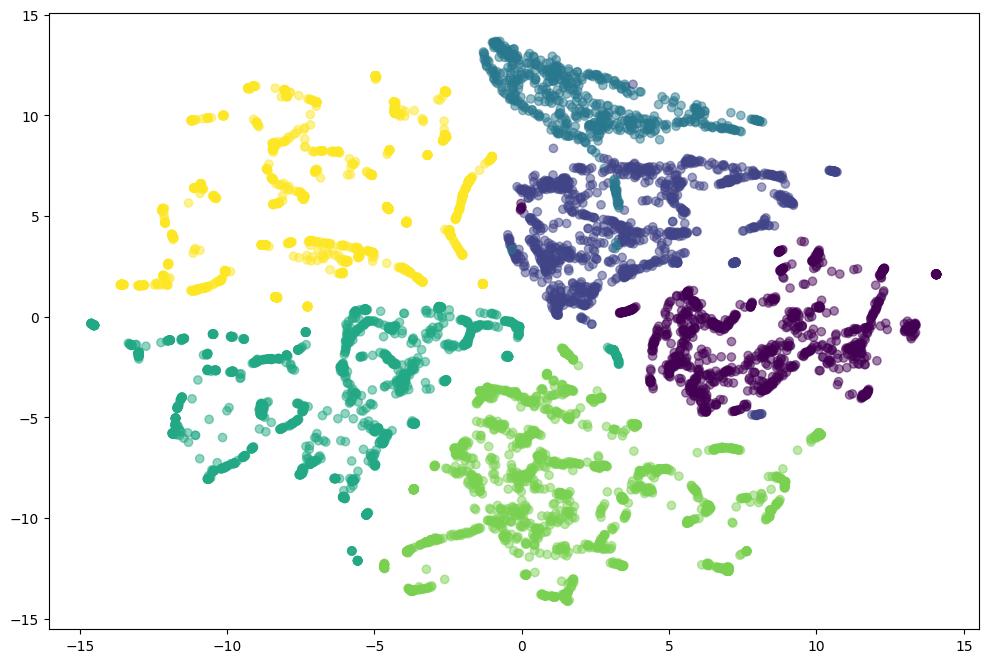

In [366]:
# Visualize the clusters
plt.figure(figsize=(12, 8))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=df_labels.values.flatten(), cmap='viridis', marker='o', alpha=0.5)

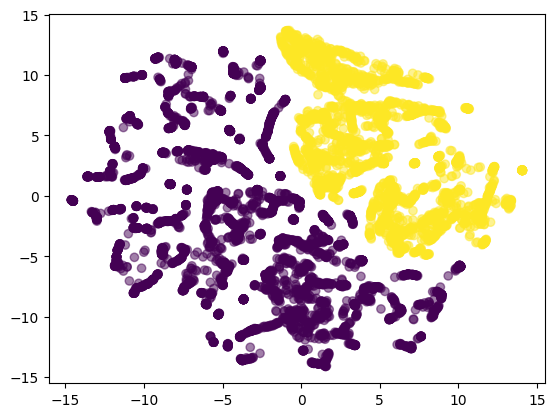

In [367]:
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=cluster_labels, cmap='viridis', marker='o', alpha=0.5)

### **Dimensionality Reduction (PCA)**

In [368]:
# Since we cannot visualize high-dimensional space directly, we can use PCA to project it down to 2D
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_filtered)

# Create a DataFrame containing the 2D projection of the data and the cluster labels
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [371]:
from sklearn.cluster import KMeans
import numpy as np

# Apply KMeans with 2 clusters
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, tol=0.0001, random_state=10)
cluster_labels = kmeans.fit_predict(pca_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [372]:
score = silhouette_score(pca_df, cluster_labels)
print("Silhouette Score", score)
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(df_labels.values.flatten(), cluster_labels)}")
print(f"Normalized Mutual Information: {metrics.normalized_mutual_info_score(df_labels.values.flatten(), cluster_labels)}")
print(f"V-measure: {metrics.v_measure_score(df_labels.values.flatten(), cluster_labels)}")

Silhouette Score 0.5999271244431157
Adjusted Rand Index: 0.32194577961295695
Normalized Mutual Information: 0.5470404369191778
V-measure: 0.5470404369191777


In [373]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=10)
tsne_results = tsne.fit_transform(pca_df)
# Create a DataFrame to hold the t-SNE results and the cluster assignments
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7663 samples in 0.005s...
[t-SNE] Computed neighbors for 7663 samples in 0.332s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7663
[t-SNE] Computed conditional probabilities for sample 2000 / 7663
[t-SNE] Computed conditional probabilities for sample 3000 / 7663
[t-SNE] Computed conditional probabilities for sample 4000 / 7663
[t-SNE] Computed conditional probabilities for sample 5000 / 7663
[t-SNE] Computed conditional probabilities for sample 6000 / 7663
[t-SNE] Computed conditional probabilities for sample 7000 / 7663
[t-SNE] Computed conditional probabilities for sample 7663 / 7663
[t-SNE] Mean sigma: 0.040982
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.713921
[t-SNE] KL divergence after 300 iterations: 1.731357


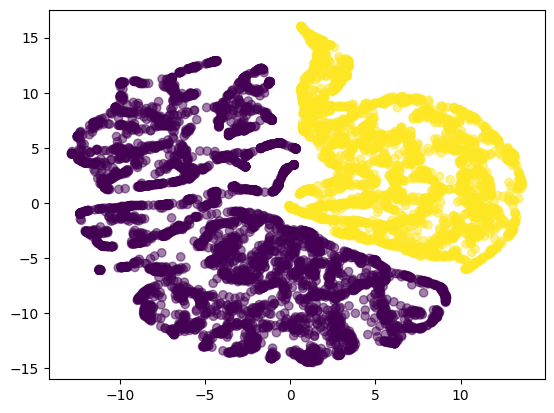

In [375]:
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=cluster_labels, cmap='viridis', marker='o', alpha=0.5)

## **DBScan**

### **Finding best parameters**

In [346]:
from sklearn.cluster import DBSCAN

# Range of `eps` values to try: smaller steps in a lower range
eps_values = np.linspace(1.0, 3.0, 100)  # Adjust this range based on your visualizations

# You may adjust min_samples again based on domain knowledge
min_samples = 2 * df_filtered.shape[1]  # As an example

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(df_filtered)

    # Number of clusters and noise points
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)

    # Consider clusters only if more than one and not all are noise
    if 1 < n_clusters < len(set(dbscan_labels)):
        silhouette = silhouette_score(df_filtered, dbscan_labels)
        print(f"eps: {eps:.2f}, min_samples: {min_samples}, clusters: {n_clusters}, noise: {n_noise}, silhouette: {silhouette}")
    else:
        print(f"eps: {eps:.2f}, min_samples: {min_samples}, single cluster or noise")

# Based on the output, choose the `eps` value that gives a reasonable balance of number of clusters, noise points, and silhouette score.

eps: 1.00, min_samples: 60, clusters: 6, noise: 1578, silhouette: 0.22494249212491454
eps: 1.02, min_samples: 60, clusters: 4, noise: 1464, silhouette: 0.39648937297490644
eps: 1.04, min_samples: 60, clusters: 4, noise: 1382, silhouette: 0.4020407606520735
eps: 1.06, min_samples: 60, clusters: 4, noise: 1315, silhouette: 0.40752983632311407
eps: 1.08, min_samples: 60, clusters: 4, noise: 1250, silhouette: 0.4127648381557306
eps: 1.10, min_samples: 60, clusters: 4, noise: 1184, silhouette: 0.4204780600599319
eps: 1.12, min_samples: 60, clusters: 4, noise: 1143, silhouette: 0.4245536572961535
eps: 1.14, min_samples: 60, clusters: 4, noise: 1076, silhouette: 0.429329053323771
eps: 1.16, min_samples: 60, clusters: 3, noise: 1014, silhouette: 0.519596909391842
eps: 1.18, min_samples: 60, clusters: 3, noise: 979, silhouette: 0.5240375064498589
eps: 1.20, min_samples: 60, clusters: 3, noise: 955, silhouette: 0.5270757444164866
eps: 1.22, min_samples: 60, clusters: 3, noise: 935, silhouette: 0

### **Clustering**

In [380]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2.82, min_samples=60)
dbscan_labels = dbscan.fit_predict(df_filtered)

print("DBSCAN labels:", np.unique(dbscan.labels_))

DBSCAN labels: [-1  0  1]


In [379]:
score = silhouette_score(df_filtered, dbscan_labels)
print("Silhouette Score", score)
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(df_labels.values.flatten(), dbscan_labels)}")
print(f"Normalized Mutual Information: {metrics.normalized_mutual_info_score(df_labels.values.flatten(), dbscan_labels)}")
print(f"V-measure: {metrics.v_measure_score(df_labels.values.flatten(), dbscan_labels)}")

Silhouette Score 0.47164078656108954
Adjusted Rand Index: 0.32035169068878194
Normalized Mutual Information: 0.5447016566839696
V-measure: 0.5447016566839696


In [348]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=10)
tsne_results = tsne.fit_transform(df_filtered)
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7663 samples in 0.008s...
[t-SNE] Computed neighbors for 7663 samples in 1.232s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7663
[t-SNE] Computed conditional probabilities for sample 2000 / 7663
[t-SNE] Computed conditional probabilities for sample 3000 / 7663
[t-SNE] Computed conditional probabilities for sample 4000 / 7663
[t-SNE] Computed conditional probabilities for sample 5000 / 7663
[t-SNE] Computed conditional probabilities for sample 6000 / 7663
[t-SNE] Computed conditional probabilities for sample 7000 / 7663
[t-SNE] Computed conditional probabilities for sample 7663 / 7663
[t-SNE] Mean sigma: 0.215433
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.651176
[t-SNE] KL divergence after 300 iterations: 1.795248


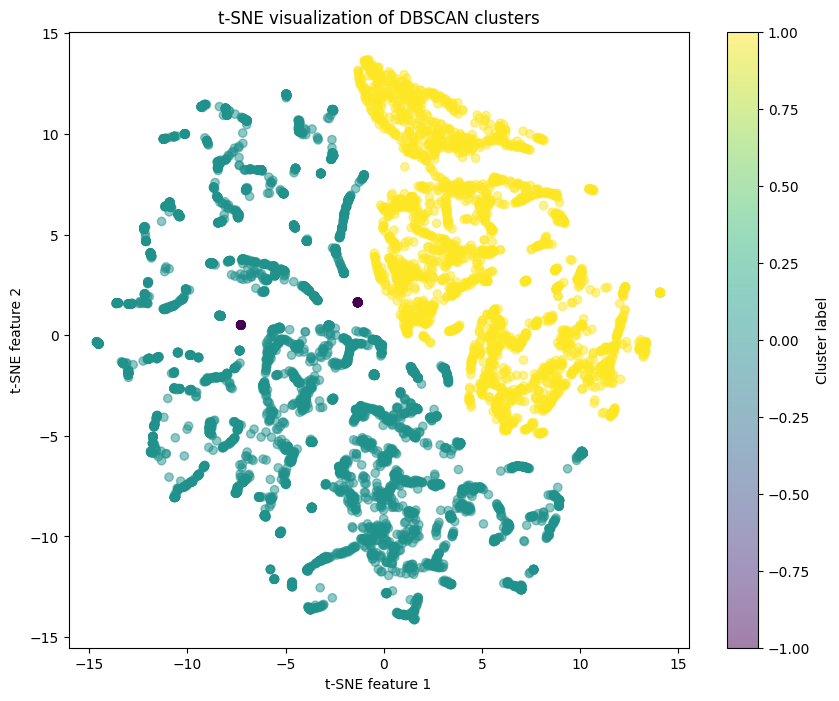

In [349]:
# Plot the t-SNE result with the cluster assignments
plt.figure(figsize=(10, 8))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=dbscan_labels, cmap='viridis', marker='o', alpha=0.5)
plt.title('t-SNE visualization of DBSCAN clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.colorbar(label='Cluster label')
plt.show()

### **Dimensionality Reduction (PCA)**

In [350]:
# Since we cannot visualize high-dimensional space directly, we can use PCA to project it down to 2D
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_filtered)

# Create a DataFrame containing the 2D projection of the data and the cluster labels
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [351]:
from sklearn.cluster import DBSCAN

# Range of `eps` values to try: smaller steps in a lower range
eps_values = np.linspace(0.1, 2.0, 100)  # Adjust this range based on your visualizations

# You may adjust min_samples again based on domain knowledge
min_samples = 2 * pca_df.shape[1]  # As an example

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(pca_df)

    # Number of clusters and noise points
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)

    # Consider clusters only if more than one and not all are noise
    if 1 < n_clusters < len(set(dbscan_labels)):
        silhouette = silhouette_score(pca_df, dbscan_labels)
        print(f"eps: {eps:.2f}, min_samples: {min_samples}, clusters: {n_clusters}, noise: {n_noise}, silhouette: {silhouette}")
    else:
        print(f"eps: {eps:.2f}, min_samples: {min_samples}, single cluster or noise")

# Based on the output, choose the `eps` value that gives a reasonable balance of number of clusters, noise points, and silhouette score.

eps: 0.10, min_samples: 4, clusters: 51, noise: 375, silhouette: -0.08886763882493891
eps: 0.12, min_samples: 4, clusters: 37, noise: 261, silhouette: 0.14629846777988384
eps: 0.14, min_samples: 4, clusters: 31, noise: 172, silhouette: 0.1740333288585519
eps: 0.16, min_samples: 4, clusters: 23, noise: 117, silhouette: 0.17872873369966852
eps: 0.18, min_samples: 4, clusters: 19, noise: 84, silhouette: 0.19850360249358914
eps: 0.20, min_samples: 4, clusters: 12, noise: 64, silhouette: 0.2545746081737718
eps: 0.22, min_samples: 4, clusters: 6, noise: 45, silhouette: 0.48111826919151146
eps: 0.23, min_samples: 4, clusters: 7, noise: 29, silhouette: 0.46074724811937556
eps: 0.25, min_samples: 4, clusters: 7, noise: 18, silhouette: 0.46072200764597027
eps: 0.27, min_samples: 4, clusters: 6, noise: 14, silhouette: 0.48591141785876013
eps: 0.29, min_samples: 4, clusters: 5, noise: 12, silhouette: 0.5413217013371102
eps: 0.31, min_samples: 4, clusters: 4, noise: 10, silhouette: 0.55938438309334

In [352]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.77, min_samples=4)
dbscan_labels = dbscan.fit_predict(pca_df)

In [361]:
score = silhouette_score(pca_df, dbscan_labels)
print("Silhouette Score", score)
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(df_labels.values.flatten(), dbscan_labels)}")
print(f"Normalized Mutual Information: {metrics.normalized_mutual_info_score(df_labels.values.flatten(), dbscan_labels)}")
print(f"V-measure: {metrics.v_measure_score(df_labels.values.flatten(), dbscan_labels)}")

Silhouette Score 0.3816819184923376
Adjusted Rand Index: 0.3218986259455223
Normalized Mutual Information: 0.5466129597097896
V-measure: 0.5466129597097895


In [357]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=10)
tsne_results = tsne.fit_transform(pca_df)
# Create a DataFrame to hold the t-SNE results and the cluster assignments
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7663 samples in 0.014s...
[t-SNE] Computed neighbors for 7663 samples in 0.255s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7663
[t-SNE] Computed conditional probabilities for sample 2000 / 7663
[t-SNE] Computed conditional probabilities for sample 3000 / 7663
[t-SNE] Computed conditional probabilities for sample 4000 / 7663
[t-SNE] Computed conditional probabilities for sample 5000 / 7663
[t-SNE] Computed conditional probabilities for sample 6000 / 7663
[t-SNE] Computed conditional probabilities for sample 7000 / 7663
[t-SNE] Computed conditional probabilities for sample 7663 / 7663
[t-SNE] Mean sigma: 0.040982
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.713921
[t-SNE] KL divergence after 300 iterations: 1.731357


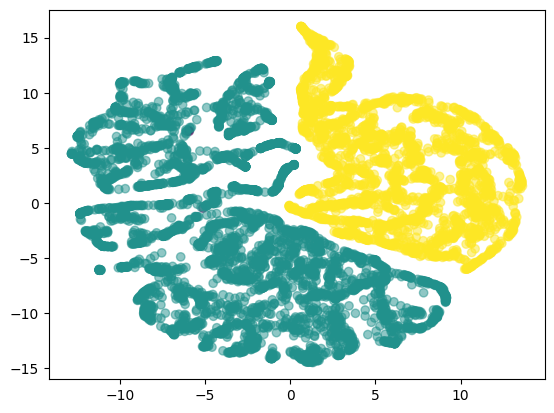

In [358]:
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=dbscan_labels, cmap='viridis', marker='o', alpha=0.5)

# **Insights**

In [382]:
tsne_df['original_label'] = df_labels.values.flatten()
tsne_df['k_means_label'] = cluster_labels
tsne_df['dbscan_label'] = dbscan_labels

In [383]:
# Cross Tabulation

# Create a contingency table for k_means_label vs original_label
contingency_kmeans = pd.crosstab(tsne_df['original_label'], tsne_df['k_means_label'])

# Create a contingency table for dbscan_label vs original_label
contingency_dbscan = pd.crosstab(tsne_df['original_label'], tsne_df['dbscan_label'])

contingency_kmeans, contingency_dbscan

(k_means_label      0     1
 original_label            
 1                  0  1102
 2                  0  1081
 3                  0   605
 4               1517     0
 5               1739     0
 6               1619     0,
 dbscan_label    -1     0     1
 original_label                
 1                0     0  1102
 2                0     0  1081
 3                0     0   605
 4                0  1517     0
 5                0  1739     0
 6               65  1554     0)

**K-means Clustering**

**Label 0** from k-means has been assigned to all instances of SITTING (4), STANDING (5), and LAYING (6) which are the static activities.

**Label 1** from k-means has been assigned to all instances of WALKING (1), WALKING_UPSTAIRS (2), and WALKING_DOWNSTAIRS (3), which are the dynamic activities.


**DBSCAN Clustering**

**Label 0** from DBSCAN has been assigned to almost all instances of SITTING (4) and STANDING (5), and most of LAYING (6), with 65 instances of LAYING labeled as noise (indicated by -1).

**Label 1** from DBSCAN has been assigned to all instances of WALKING (1), WALKING_UPSTAIRS (2), and WALKING_DOWNSTAIRS (3), matching the k-means dynamic activity group.